# Reconstruction and analysis of B-cell lineage trees from single cell data using Immcantation


![](assets/dowser-tutorial-cover.png)



Human B cells play a fundamental role in the adaptive immune response to infection and vaccination, as well as the pathology of allergies and many autoimmune diseases. Central to all of these processes is the fact that B cells are an evolutionary system, and undergo rapid somatic hypermutation and antigen-driven selection as part of the adaptive immune response. The similarities between this B cell response and evolution by natural selection have made phylogenetic methods a powerful means of characterizing important processes, such as immunological memory formation. Recent methodological work has led to the development of phylogenetic methods that adjust for the unique features of B cell evolution. Further, advances in single cell sequencing can now provide an unprecedented resolution of information, including linked heavy and light chain data, as well as the associated transcriptional states of individual B cells. In this tutorial, we show how single cell information can be integrated into B cell phylogenetic analysis using the Immcantation suite (Immcantation.org).

**This tutorial covers:**

Beginning with processed single cell RNA-seq (scRNA-seq) + BCR data from 10X Genomics, we will show:

- how cell type annotations can be associated with BCR sequences,
- how clonal clusters can be identified, and 
- how B cell phylogenetic trees can be built and visualized using these data sources.

[Watch on YouTube](https://youtu.be/ZNOSQGh22X4) a recorded version of this tutorial, that was presented at the [Adaptive Immune Receptor Repertoires Webinar Series](https://www.antibodysociety.org/learningcenter/adaptive-immune-receptor-repertoires-webinar-series/) organized by the [AIRR Community](http://airr-community.org/) and [The Antibody Society](https://www.antibodysociety.org/) (November 9, 2021).

## Resources

- You can email [immcantation@googlegroups.com](mailto:immcantation@googlegroups.com) with any questions or issues.
- Documentation: http://immcantation.org
- Source code and bug reports: https://bitbucket.org/kleinstein/immcantation
- Docker/Singularity container for this lab: https://hub.docker.com/r/immcantation/lab

## How to use the notebook

Jupyter Notebook documentation: https://jupyter-notebook.readthedocs.io/en/stable/

**Ctrl+Enter** will run the code in the selected cell and **Shift+Enter** will run the code and move to the following cell.

## Inside this container

This container comes with software and example data that is ready to use. The commands `versions report` and `builds report` show the versions and dates respectively of the tools and data.

### Software versions
Use this command to list the software versions

In [1]:
%%bash
versions report

immcantation: devel
date: 2021.11.08

presto: 0.7.0
changeo: 1.2.0
alakazam: 1.2.0
shazam: 1.1.0.999
tigger: 1.0.0.999
scoper: 1.2.0
dowser: 0.1.0
enchantr: 0.0.0
prestor: 0.0.7
rabhit: 0.1.5
rdi: 1.0.0
igphyml: 1.1.3

airr-py: 1.3.1
airr-r: 1.3.0
blast: 2.9.0
cd-hit: 4.8.1
igblast: 1.17.1
muscle: 3.8.425
phylip: 3.697
vsearch: 2.13.6


### Build versions
Use this command to list the date and changesets used during the image build.

In [2]:
%%bash
builds report

date: 2021-11-08 13:15:32 UTC
immcantation: 4.3.0-4-ge3606f39a8a8+
presto: 0.7.0-1-gb503b521e246
changeo: 1.2.0
alakazam: 1.2.0
shazam: 1.1.0-15-g02106e891749
tigger: 6c31d6a59167+
rdi: d27b9067cab6+
scoper: 1.2.0
prestor: 0.0.7


### Example data used in the tutorial


- `../data/bcr_phylo_tutorial/BCR.data.tsv`: B-Cell Receptor Data. Adaptive Immune Receptor Repertoire (AIRR) tsv BCRs already aligned to IMGT V, D, and J genes. This process is not covered in this tutorial. To learn more visit  https://immcantation.readthedocs.io/en/stable/tutorials/tutorials.html


- `../data/bcr_phylo_tutorial/GEX.data.rds`: Gene Expression Data. This file contains a Seurat object with RNA-seq data already processed and annotated. Processing and annotation are not covered in this tutorial. You can learn more on these topics in Seurat's documentation and tutorials: https://satijalab.org/seurat/articles/pbmc3k_tutorial.html

These two files are subsamples of the original 10x scRNA-seq and BCR sequencing data from Turner et al. (2020) *Human germinal centres engage memory and naive B cells after influenza vaccination* Nature. 586, 127–132 [link](https://www.nature.com/articles/s41586-020-2711-0) The study consists of blood and limph node samples taken from a single patient at mulitple time points following influenza vaccination.

Note: The example files are available for download [here](https://yale.box.com/shared/static/96y1rlu4ujerprxr53qxw87g7ybc1y99).

## Outline of tutorial

1. Combining gene expression and BCR sequences.

1. Identifying clonal clusters, reconstruct germlines.

1. Building and visualizing trees.

1. Tree analysis, detecting ongoing evolution.




## The R session


The next two lines of code are required to be able to use R magic and run R code in this Jupyter notebook.

In [3]:
# R for Python
# Enable use of R magic to run R code
import rpy2.rinterface
%load_ext rpy2.ipython

The is the working directory:

In [4]:
%%R
getwd()

[1] "/home/magus/notebooks"


The example files are expected to be in `../data/bcr_phylo_tutorial`.

In [5]:
%%R
list.files("../data/bcr_phylo_tutorial")

[1] "BCR.data.final.tsv" "BCR.data.tsv"       "GEX.data.rds"      


## Read in data

The example files are expected to be in `../data/bcr_phylo_tutorial`. If you are using a different path, update the code in the cell bellow accordingly.

In [6]:
%%R
suppressPackageStartupMessages(library(alakazam))
suppressPackageStartupMessages(library(Seurat))

# Read BCR data
bcr_db <- readChangeoDb("../data/bcr_phylo_tutorial/BCR.data.tsv")

# Read GEX data
gex_db <- readRDS("../data/bcr_phylo_tutorial/GEX.data.rds")


## Inspect the data objects



## The gene expression Seurat object

`print` can be used to obtain a general overview of the Seurat object (number of features, number of samples...).

In [7]:
%%R
library(Seurat)
# Object summary
print(gex_db)

An object of class Seurat 
18989 features across 3865 samples within 1 assay 
Active assay: RNA (18989 features, 1726 variable features)
 2 dimensional reductions calculated: pca, umap


`Idents` reports the cell ID and identities. The first annotation in this blood sample is a TCR.

In [8]:
%%R
# Cell type annotations
head(Idents(gex_db),1)

P05_FNA_12_Y1_TCACAAGTCAAACAAG 
                         CD4 T 
Levels: CD4 T Naive B CD8 T DC/Monocyte GC B NK RMB PB


## The immune repertoire data

The default file format for all functions in Immcantation is the AIRR-C format as of release 4.0.0. The rearrangement data is stored in a table where each row is a sequence, and each column an annotation fields. To learn more about this format (including the valid field names and their expected values), visit the [AIRR-C Rearrangement Schema documentation](https://docs.airr-community.org/en/stable/datarep/rearrangements.html#fields).

In [9]:
%%R
suppressPackageStartupMessages(library(dplyr))
# Object summary
head(bcr_db,1)

# A tibble: 1 × 71
  sequence_id sequence rev_comp productive v_call d_call j_call sequence_alignm…
  <chr>       <chr>    <lgl>    <lgl>      <chr>  <chr>  <chr>  <chr>           
1 CCACTACCAG… ATACTCT… NA       TRUE       IGHV4… IGHD3… IGHJ3… CAGGTGCAGCTGCAG…
# … with 63 more variables: germline_alignment <lgl>, junction <chr>,
#   junction_aa <lgl>, v_cigar <lgl>, d_cigar <lgl>, j_cigar <lgl>,
#   vj_in_frame <lgl>, stop_codon <lgl>, v_sequence_start <dbl>,
#   v_sequence_end <dbl>, v_germline_start <dbl>, v_germline_end <dbl>,
#   np1_length <dbl>, d_sequence_start <dbl>, d_sequence_end <dbl>,
#   d_germline_start <dbl>, d_germline_end <dbl>, np2_length <dbl>,
#   j_sequence_start <dbl>, j_sequence_end <dbl>, j_germline_start <dbl>, …


It is possible to subset columns using regular `R` functions. The cell below shows how to subset some fields of interest for the first sequence in the table.

In [10]:
%%R
# check out select columns
head(select(bcr_db, cell_id, v_call, j_call, sample, day),1)

# A tibble: 1 × 5
  cell_id            v_call      j_call   sample            day
  <chr>              <chr>       <chr>    <chr>           <dbl>
1 CCACTACCAGTATCTG-1 IGHV4-59*01 IGHJ3*02 P05_FNA_3_12_Y1    12


## Standardize cell IDs

Both of the example datasets have been processed separately, and use slighty different cell identifiers. To consolidate the data into one object, we need to standardize the cell identifiers. This step could be different, or not necessary at all, with other datasets.

In [11]:
%%R
# Make cell IDs in BCR match those in Seurat Object
bcr_db$cell_id_unique = paste0(bcr_db$sample, "_", bcr_db$cell_id)
bcr_db$cell_id_unique = gsub("-1","", bcr_db$cell_id_unique)
bcr_db$cell_id_unique[1]

[1] "P05_FNA_3_12_Y1_CCACTACCAGTATCTG"


## Different order

In addition, the cells in both datasets are not presented in the same order.

In [12]:
%%R
# First id in the BCR data
bcr_db$cell_id_unique[1]

[1] "P05_FNA_3_12_Y1_CCACTACCAGTATCTG"


In [13]:
%%R
# First id in the GEX data
Cells(gex_db)[1]

[1] "P05_FNA_12_Y1_TCACAAGTCAAACAAG"


Having common cell identifiers, we will be able to bring BCR data into the Seurat object, or the gene expression and annotation data from the Seurat object into the BCR table, by matching `cell_id_unique`.

## Add BCR data to Seurat object

1. Find the GEX cells in the BCR data

1. Label GEX data with BCR data availability

1. Plot UMAP

### Find the GEX cells in the BCR data

The vector `match.index` contains the position of the GEX cells in the BCR data. If there is not match, the value will be `NA`.

In [14]:
%%R
# match index to find the position of the GEX cells in the BCR data
match.index = match(Cells(gex_db), bcr_db$cell_id_unique)

# In this data, not all cells are B cells. 
# What proportion of cells don’t have BCRs?
mean(is.na(match.index))

[1] 0.2455369


In [15]:
%%R
# Just to double check cell ids in the GEX match cells ids in BCR data
# Should be 1
mean(Cells(gex_db) == bcr_db$cell_id_unique[match.index],na.rm=TRUE)


[1] 1


### Label GEX data with BCR data availability


With the matching indices, it is possible to label the GEX cells with `TRUE` or `FALSE` to indicate whether there is BCR information available for the cell, and visualize this information in the UMAP plot.

In [16]:
%%R

# label whether BCR found in cell
gex_db$contains_bcr = !is.na(match.index)



### plot UMAP

We expect that for a large proportion of cells labelled as BCR, there will be BCR sequencing data available, and these cells will be highlighted in the UMAP plot.

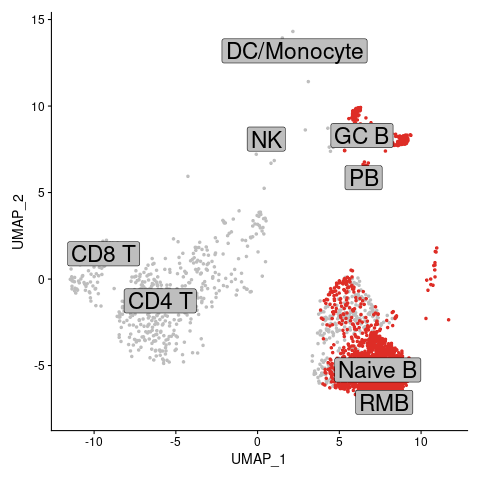

In [17]:
%%R

# List of cells with BCRs
highlighted.cells = Cells(gex_db)[which(gex_db$contains_bcr)]

# Plot UMAP with BCR-containing cells
DimPlot(object = gex_db, reduction = "umap", cells.highlight = highlighted.cells, label =
   TRUE, cols="gray", pt.size = 1.0, label.size=8, label.box=TRUE) + NoLegend()



## Add GEX data to BCR object

1. Find the BCR cells in the GEX data

1. Transfer GEX annotations into the BCR data

1. Add UMAP coordinates to the BCR data

1. Remove cells without GEX data

1. Ensure information transferred from Seurat object

### Find the BCR cells in the GEX data

We repeat the `match` step, reversing the order. The vector `match.index` will now contain the positions of the BCR sequences in the GEX data.


In [18]:
%%R

# Match indices to find the position of the BCR cells in the GEX data
# Different from finding the position of the GEX cells in the BCR data!
match.index = match(bcr_db$cell_id_unique, Cells(gex_db))

Some BCRs don't have GEX information. This can happen, for example, if the cell for which BCR's are covered didn't pass the GEX processing and quality controls thresholds.

In [19]:
%%R
# What proportion of BCRs don’t have GEX information?
mean(is.na(match.index))

[1] 0.09243697


### Transfer GEX annotations into the BCR data

The GEX cell annotations can be added as additional columns in the BCR table.

In [20]:
%%R

# Add annotations to BCR data
cell.annotation = as.character(Idents(gex_db))
bcr_db$gex_annotation= unlist(lapply(match.index,function(x){ifelse(is.na(x),NA, cell.annotation[x])}))
bcr_db$gex_annotation[1:5]

[1] NA        "Naive B" "Naive B" NA        "GC B"   


### Add UMAP coordinates to BCR data

The UMAP coordinates can be added as additional columns in the BCR table as well.

In [21]:
%%R
# Add UMAP coordinates to BCR data
umap1 = gex_db@reductions$umap@cell.embeddings[,1]
umap2 = gex_db@reductions$umap@cell.embeddings[,2]
bcr_db$gex_umap1= unlist(lapply(match.index, function(x){ifelse(is.na(x),NA, umap1[x])}))
bcr_db$gex_umap2= unlist(lapply(match.index, function(x){ifelse(is.na(x),NA, umap2[x])}))
bcr_db[1:5,] %>%
select(cell_id_unique,gex_umap1,gex_umap2,gex_annotation)

# A tibble: 5 × 4
  cell_id_unique                   gex_umap1 gex_umap2 gex_annotation
  <chr>                                <dbl>     <dbl> <chr>         
1 P05_FNA_3_12_Y1_CCACTACCAGTATCTG     NA        NA    <NA>          
2 P05_FNA_5_Y1_GACTGCGCAAGCCTAT         7.96     -5.60 Naive B       
3 P05_FNA_60_Y1_GGCAATTAGACAGAGA        8.65     -4.55 Naive B       
4 P05_FNA_2_5_Y1_CGCGTTTCAGATGGGT      NA        NA    <NA>          
5 P05_FNA_2_60_Y1_AGTGTCACACTGTTAG      6.15      8.44 GC B          


### Remove cells without GEX data

In [22]:
%%R
# Remove cells that didn’t match
bcr_db = filter(bcr_db, !is.na(gex_annotation))

### Ensure information transferred from Seurat object

The BCR data table now has the UMAP coordinates. We can reproduce **part** of the UMAP plot with standard `ggplot` commands. This plot will have a similar shape to the GEX UMAP, but will only show points for which both GEX and BCR data is available.

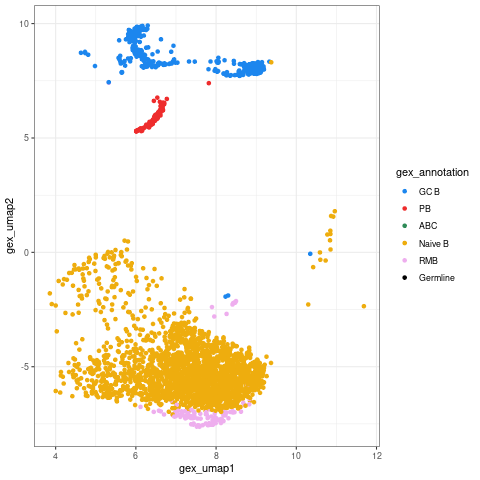

In [23]:
%%R
suppressPackageStartupMessages(library(ggplot2))
# Set up color palette for annotations
col_anno = c(
   "GC B"="dodgerblue2", "PB"="firebrick2", "ABC"="seagreen",
   "Naive B"="darkgoldenrod2", "RMB"="plum2", "Germline"="black")
# Plot UMAP from bcr_db
bcr_umap <- ggplot(bcr_db) +
   geom_point(aes(x = gex_umap1, y = gex_umap2, color = gex_annotation)) +
   scale_colour_manual(values=col_anno) +
   theme_bw()
bcr_umap

### Color the UMAP by isotype

The BCR data frame contains additional annotation fields, such us the isotype, that can also be visualized on the UMAP. We expect that naive cell express IgM. The germinal center and plasmablast cells, primarily express IgG and IgA.

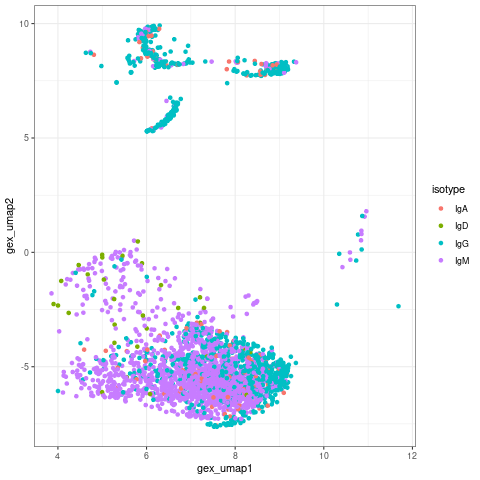

In [24]:
%%R
# Plot isotype on UMAP
ggplot(bcr_db) +
   geom_point(aes(x=gex_umap1,y = gex_umap2,color = isotype)) +
   theme_bw()

## Identifying clonal clusters


**Goal:** Partition (cluster) sequences into clonally related lineages. Each lineage is a group of sequences that came from the same original naive cell.

Summary of the key steps:
- *Determine clonal clustering threshold:* sequences which are under this cut-off are clonally related.
- *Assign clonal groups:* add an annotation (`clone_id`) that can be used to identify a group of sequences that came from the same original naive cell.
- *Reconstruct germline sequences:* figure out the germline sequence of the common ancestor, before mutations are introduced during clonal expansion and SMH.

![](assets/clonalexpansion.png)


### Picking a threshold using shazam

*Gupta et al. (2015)*

<img src="assets/hclust.png" width="35%" align="left"><img src="assets/distNearest.png" width="30%" align="left">

We first split sequences into groups that share the same V and J gene assignments and that have the same junction (or equivalently CDR3) length. This is based on the assumption that members of a clone will share all of these properties. `distToNearest` performs this grouping step, then counts the number of mismatches in the junction region between all pairs of sequences in eaach group and returns the smallest non-zero value for each sequence. At the end of this step, a new column (`dist_nearest`) which contains the distances to the closest non-identical sequence in each group will be added to the BCR table. `findThreshold` uses the distribution of distances calculated in the previous step to determine an appropriate threshold for the dataset. This can be done using either a `density` or `mixture` based method. 

### distToNearest

In [25]:
%%R
suppressPackageStartupMessages(library(shazam))
# Find threshold using heavy chains
dist_ham <- distToNearest(filter(bcr_db, locus=="IGH"))
head(dist_ham) %>%
select(cell_id_unique, dist_nearest)


# A tibble: 6 × 2
  cell_id_unique                   dist_nearest
  <chr>                                   <dbl>
1 P05_FNA_5_Y1_GACTGCGCAAGCCTAT          0.0667
2 P05_FNA_60_Y1_GGCAATTAGACAGAGA         0.0667
3 P05_FNA_2_60_Y1_AGTGTCACACTGTTAG       0.0196
4 P05_FNA_2_60_Y1_CGGGTCAGTCTGGAGA       0.0196
5 P05_FNA_60_Y1_ACTGATGTCCTAGAAC         0.0196
6 P05_FNA_60_Y1_CTGAAACAGTGAAGTT         0.0196


### findThreshold

The figure shows the distance-to-nearest distribution for the repertoire. Typically, the distribution is bimodal. The first mode (on the left) represents sequences that have at least one clonal relative in the dataset, while the second mode (on the right) is representative of the sequences that do not have any clonal relatives in the data (sometimes called "singletons"). A reasonable threshold will separate these two modes of the distribution.

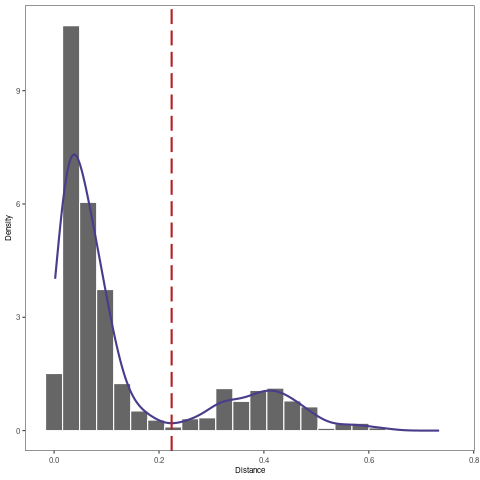

In [26]:
%%R
output <- findThreshold(dist_ham$dist_nearest)
threshold <- output@threshold
# Visualize the distance-to-nearest distribution and threshold
plotDensityThreshold(output)


### Performing clustering using scoper

Once a threshold is decided, we perform the clonal assignment. At the end of this step, the BCR table will have an additional column (`clone_id`) that provides an identifier for each sequence to indicate which clone it belongs to (i.e., sequences that have the same identifier are clonally-related). *Note that these identifiers are only unique to the dataset used to carry out the clonal assignments.*

Note: will print out “running in bulk mode” because the subsampled example data has only heavy chains. [Other options](https://scoper.readthedocs.io/en/stable/topics/hierarchicalClones/#single-cell-data) available if light chains are included.


In [27]:
%%R
suppressPackageStartupMessages(library(scoper))
# Assign clonal clusters
results <- hierarchicalClones(dist_ham,threshold=threshold)
results_db <- as.data.frame(results)
head(results_db) %>%
select(cell_id_unique, clone_id)

R[write to console]: Running defineClonesScoper in bulk mode



                    cell_id_unique clone_id
1 P05_FNA_3_28_Y1_ATGCGATCAACTGCTA        1
2 P05_FNA_2_60_Y1_GCATGTAGTTATGTGC        1
3 P05_FNA_2_60_Y1_TACAGTGAGGCGACAT        1
4 P05_FNA_2_60_Y1_ACGGCCAGTCGCATAT        2
5   P05_FNA_12_Y1_CACACCTTCTACCAGA        2
6 P05_FNA_2_60_Y1_TTGGCAAAGAGTAAGG        3


### Visualize clone size distribution

Most real datasets, will have most clones of size 1 (one sequence). In this tutorial, we processed data to remove most of singleton clone and we don't see the much higher peak at 1 that we would normally expect.

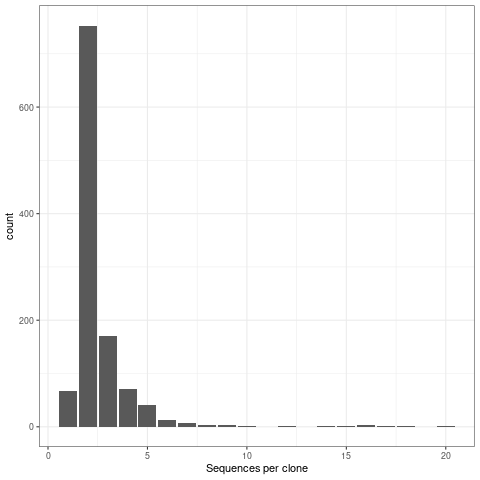

In [28]:
%%R
# get clone sizes using dplyr functions
clone_sizes <- countClones(results_db)
# Plot cells per clone
ggplot(clone_sizes, aes(x=seq_count))+
geom_bar() + theme_bw() +
xlab("Sequences per clone")



## Reconstruct clonal germlines using dowser

The goal is to reconstruct the sequence of the unmutated ancestor of each clone. We use a reference database of known alleles ([IMGT](http://www.imgt.org)). Because it is very difficult to ccurately infer the D region and the junction region for BCR sequences, we mask this region with `N`. 

Note: If you opted for a native installation to run this tutorial, you can obtain reference germlines from IMGT with:
```
    git clone https://bitbucket.org/kleinstein/immcantation
    immcantation/scripts/fetch_imgtdb.sh
```

In [29]:
%%R
suppressPackageStartupMessages(library(dowser))

# read in IMGT data if downloaded on your own (above)
# and update `dir` to use the path to your `human/vdj` folder
# references = readIMGT(dir = "human/vdj/")

# read in IMGT data if using in Docker image
references = readIMGT(dir = "/usr/local/share/germlines/imgt/human/vdj")
# Reconstruct germlines
results_db = createGermlines(results_db, references)
# Check output column
results_db$germline_alignment_d_mask[1]


[1] "Read in 1115 from 17 fasta files"
<simpleError in rep("V", nchar(v_seq)): invalid 'times' argument>
<simpleError in rep("V", nchar(v_seq)): invalid 'times' argument>
[1] "CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGAAGCCTTCGGAGACCCTGTCCCTCACCTGCGCTGTCTCTGGTTACTCCATCAGC.........AGTGGTTACTACTGGGGCTGGATCCGGCAGCCCCCAGGGAAGGGGCTGGAGTGGATTGGGAGTATCTATCATAGT.........GGGAGCACCTACTACAACCCGTCCCTCAAG...AGTCGAGTCACCATATCAGTAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTGAGCTCTGTGACCGCCGCAGACACGGCCGTGTATTACTGTGCGAGANNNNNNNNNNNNNNNNNNNNNNNNTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG"


# Building and visualizing trees

1. Formatting clones

1. Tree building

1. Visualize trees

1.  Reconstruct intermediate sequences

## Formatting clones with dowser

In the rearrrangemnt table, each row corresponds to a sequence, and each column is information about that sequence. We will create a new data structure, where each row is a clonal cluster, and each column is information about that clonal cluster. The function `formatClones` performs this processing and has options that are relevant to determine how the trees can be built and visualized. For example, `traits` determines the columns from the rearrangement data that will be included in the `clones` object, and will also be used to determine the uniqueness of the sequences, so they are not collapsed.


In [30]:
%%R
# Make clone objects with aligned, processed sequences
# collapse identical sequences unless differ by trait
# add up duplicate_count column for collapsed sequences
# store day, isotype, gex_annotation
# discard clones with < 5 distinct sequences
clones = formatClones(results_db,
   traits = c("day", "isotype", "gex_annotation"),
   num_fields=c("duplicate_count"), minseq=5)
clones

|======================================================|100% ~0 s remaining                              # A tibble: 66 × 4
   clone_id data       locus  seqs
   <chr>    <list>     <chr> <int>
 1 403      <airrClon> IGH      16
 2 457      <airrClon> IGH      15
 3 512      <airrClon> IGH      15
 4 823      <airrClon> IGH      15
 5 12       <airrClon> IGH      13
 6 539      <airrClon> IGH      13
 7 446      <airrClon> IGH      12
 8 1006     <airrClon> IGH       9
 9 1125     <airrClon> IGH       9
10 442      <airrClon> IGH       9
# … with 56 more rows


## Tree building with dowser

Dowser offers multiple ways to build B cell phylogenetic trees. These differ by the method used to estimate tree topology and branch lengths (e.g. maximum parsimony and maximum likelihood) and implementation (IgPhyML, PHYLIP, or R packages ape and phangorn). Each method has pros and cons.

### Maximum parsimony

This is the oldest method and very popular. It tries to minimize the number of mutations from the germline to each of the tips. It can produce misleading results when parallel mutations are present.

In [31]:
%%R
# Two options for maximum parsimony trees
# 1. phangorn
trees = getTrees(clones)

In [32]:
%%R
# 2. dnapars (PHYLIP)
trees = getTrees(clones, build="dnapars", exec="/usr/local/bin/dnapars")
head(trees)

# A tibble: 6 × 5
  clone_id data       locus  seqs trees  
  <chr>    <list>     <chr> <int> <list> 
1 403      <airrClon> IGH      16 <phylo>
2 457      <airrClon> IGH      15 <phylo>
3 512      <airrClon> IGH      15 <phylo>
4 823      <airrClon> IGH      15 <phylo>
5 12       <airrClon> IGH      13 <phylo>
6 539      <airrClon> IGH      13 <phylo>


### Standard maximum likelihood

These methods model each sequence separately. Use a markov model of the mutation process and try to find the tree, not the branch lengths, that maximizes the likehood of seen data.

In [33]:
%%R
# Two options for standard maximum likelihood trees
# 1. pml (phangorn)
trees = getTrees(clones, build="pml", sub_model="GTR")
head(trees)

[1] "sub_model GTR"
optimize edge weights:  -1558.412 --> -1549.357 
optimize base frequencies:  -1549.357 --> -1545.877 
optimize rate matrix:  -1545.877 --> -1532.272 
optimize edge weights:  -1532.272 --> -1532.212 
optimize topology:  -1532.212 --> -1532.212 
0 
optimize base frequencies:  -1532.212 --> -1531.64 
optimize rate matrix:  -1531.64 --> -1531.575 
optimize edge weights:  -1531.575 --> -1531.568 
optimize base frequencies:  -1531.568 --> -1531.56 
optimize rate matrix:  -1531.56 --> -1531.559 
optimize edge weights:  -1531.559 --> -1531.559 
optimize base frequencies:  -1531.559 --> -1531.558 
optimize rate matrix:  -1531.558 --> -1531.558 
optimize edge weights:  -1531.558 --> -1531.558 
optimize base frequencies:  -1531.558 --> -1531.558 
optimize rate matrix:  -1531.558 --> -1531.558 
optimize edge weights:  -1531.558 --> -1531.558 
[1] "sub_model GTR"
optimize edge weights:  -1157.811 --> -1155.287 
optimize base frequencies:  -1155.287 --> -1152.879 
optimize rate m

optimize edge weights:  -1094.582 --> -1094.562 
optimize topology:  -1094.562 --> -1093.304 
optimize topology:  -1093.304 --> -1093.304 
1 
optimize base frequencies:  -1093.304 --> -1093.129 
optimize rate matrix:  -1093.129 --> -1092.931 
optimize edge weights:  -1092.931 --> -1092.928 
optimize topology:  -1092.928 --> -1092.928 
0 
optimize base frequencies:  -1092.928 --> -1092.912 
optimize rate matrix:  -1092.912 --> -1092.911 
optimize edge weights:  -1092.911 --> -1092.91 
optimize base frequencies:  -1092.91 --> -1092.91 
optimize rate matrix:  -1092.91 --> -1092.91 
optimize edge weights:  -1092.91 --> -1092.91 
optimize base frequencies:  -1092.91 --> -1092.91 
optimize rate matrix:  -1092.91 --> -1092.91 
optimize edge weights:  -1092.91 --> -1092.91 
[1] "sub_model GTR"
optimize edge weights:  -1172.259 --> -1168.87 
optimize base frequencies:  -1168.87 --> -1164.813 
optimize rate matrix:  -1164.813 --> -1144.233 
optimize edge weights:  -1144.233 --> -1144.22 
optimiz

optimize edge weights:  -750.7938 --> -749.5818 
optimize base frequencies:  -749.5818 --> -746.8864 
optimize rate matrix:  -746.8864 --> -742.9538 
optimize edge weights:  -742.9538 --> -742.9323 
optimize topology:  -742.9323 --> -742.9323 
optimize topology:  -742.9323 --> -742.9323 
1 
optimize base frequencies:  -742.9323 --> -742.924 
optimize rate matrix:  -742.924 --> -742.9195 
optimize edge weights:  -742.9195 --> -742.9189 
optimize topology:  -742.9189 --> -742.9188 
0 
optimize base frequencies:  -742.9188 --> -742.9186 
optimize rate matrix:  -742.9186 --> -742.9185 
optimize edge weights:  -742.9185 --> -742.9185 
optimize base frequencies:  -742.9185 --> -742.9184 
optimize rate matrix:  -742.9184 --> -742.9184 
optimize edge weights:  -742.9184 --> -742.9184 
optimize base frequencies:  -742.9184 --> -742.9184 
optimize rate matrix:  -742.9184 --> -742.9184 
optimize edge weights:  -742.9184 --> -742.9183 
[1] "sub_model GTR"
optimize edge weights:  -1077.026 --> -107

optimize rate matrix:  -721.0957 --> -721.0957 
optimize edge weights:  -721.0957 --> -721.0957 
optimize base frequencies:  -721.0957 --> -721.0957 
optimize rate matrix:  -721.0957 --> -721.0957 
optimize edge weights:  -721.0957 --> -721.0957 
[1] "sub_model GTR"
optimize edge weights:  -848.7337 --> -843.0931 
optimize base frequencies:  -843.0931 --> -837.834 
optimize rate matrix:  -837.834 --> -822.9134 
optimize edge weights:  -822.9134 --> -822.8732 
optimize topology:  -822.8732 --> -822.8732 
0 
optimize base frequencies:  -822.8732 --> -822.6507 
optimize rate matrix:  -822.6507 --> -822.6313 
optimize edge weights:  -822.6313 --> -822.6295 
optimize base frequencies:  -822.6295 --> -822.6279 
optimize rate matrix:  -822.6279 --> -822.6278 
optimize edge weights:  -822.6278 --> -822.6278 
optimize base frequencies:  -822.6278 --> -822.6277 
optimize rate matrix:  -822.6277 --> -822.6277 
optimize edge weights:  -822.6277 --> -822.6277 
[1] "sub_model GTR"
optimize edge weig

optimize topology:  -794.0407 --> -793.6859 
optimize topology:  -793.6859 --> -793.6859 
2 
optimize base frequencies:  -793.6859 --> -793.615 
optimize rate matrix:  -793.615 --> -793.4969 
optimize edge weights:  -793.4969 --> -793.4883 
optimize topology:  -793.4883 --> -793.4883 
0 
optimize base frequencies:  -793.4883 --> -793.4844 
optimize rate matrix:  -793.4844 --> -793.4825 
optimize edge weights:  -793.4825 --> -793.4823 
optimize base frequencies:  -793.4823 --> -793.4822 
optimize rate matrix:  -793.4822 --> -793.4822 
optimize edge weights:  -793.4822 --> -793.4821 
optimize base frequencies:  -793.4821 --> -793.4821 
optimize rate matrix:  -793.4821 --> -793.4821 
optimize edge weights:  -793.4821 --> -793.4821 
[1] "sub_model GTR"
optimize edge weights:  -764.6919 --> -762.3552 
optimize base frequencies:  -762.3552 --> -758.0296 
optimize rate matrix:  -758.0296 --> -747.8792 
optimize edge weights:  -747.8792 --> -747.8727 
optimize topology:  -747.8727 --> -747.872

optimize edge weights:  -605.7638 --> -605.7638 
[1] "sub_model GTR"
optimize edge weights:  -622.2222 --> -622.013 
optimize base frequencies:  -622.013 --> -617.1457 
optimize rate matrix:  -617.1457 --> -609.3772 
optimize edge weights:  -609.3772 --> -609.3771 
optimize topology:  -609.3771 --> -609.3771 
0 
optimize base frequencies:  -609.3771 --> -609.3619 
optimize rate matrix:  -609.3619 --> -609.3615 
optimize edge weights:  -609.3615 --> -609.3615 
optimize base frequencies:  -609.3615 --> -609.3615 
optimize rate matrix:  -609.3615 --> -609.3615 
optimize edge weights:  -609.3615 --> -609.3615 
[1] "sub_model GTR"
optimize edge weights:  -898.7092 --> -898.5373 
optimize base frequencies:  -898.5373 --> -892.8802 
optimize rate matrix:  -892.8802 --> -877.7483 
optimize edge weights:  -877.7483 --> -877.6948 
optimize topology:  -877.6948 --> -877.6948 
0 
optimize base frequencies:  -877.6948 --> -877.6396 
optimize rate matrix:  -877.6396 --> -877.6362 
optimize edge weig

optimize edge weights:  -741.5418 --> -741.5418 
# A tibble: 6 × 5
  clone_id data       locus  seqs trees  
  <chr>    <list>     <chr> <int> <list> 
1 403      <airrClon> IGH      16 <phylo>
2 457      <airrClon> IGH      15 <phylo>
3 512      <airrClon> IGH      15 <phylo>
4 823      <airrClon> IGH      15 <phylo>
5 12       <airrClon> IGH      13 <phylo>
6 539      <airrClon> IGH      13 <phylo>


In [34]:
%%R
# 2. dnaml (PHYLIP)
trees = getTrees(clones, build="dnaml", exec="/usr/local/bin/dnaml")
head(trees)

# A tibble: 6 × 5
  clone_id data       locus  seqs trees  
  <chr>    <list>     <chr> <int> <list> 
1 403      <airrClon> IGH      16 <phylo>
2 457      <airrClon> IGH      15 <phylo>
3 512      <airrClon> IGH      15 <phylo>
4 823      <airrClon> IGH      15 <phylo>
5 12       <airrClon> IGH      13 <phylo>
6 539      <airrClon> IGH      13 <phylo>


### Bcell specific maximum likelihood

Similar to the standard maximum likelihood, but incorporating SHM specific mutation biases into the tree building.

In [35]:
%%R
# B cell specific maximum likelihood with IgPhyML
# This code is commented out because of long running time
# trees = getTrees(clones, build="igphyml", exec="/usr/local/share/igphyml/src/igphyml", nproc=2)
# head(trees)

NULL


## Plotting trees with dowser and ggtree

All tree building methods are plotted using the same method in dowser, `plotTrees`.

In [36]:
%%R
# Plot all trees
plots = plotTrees(trees, tips="isotype", tipsize=2)

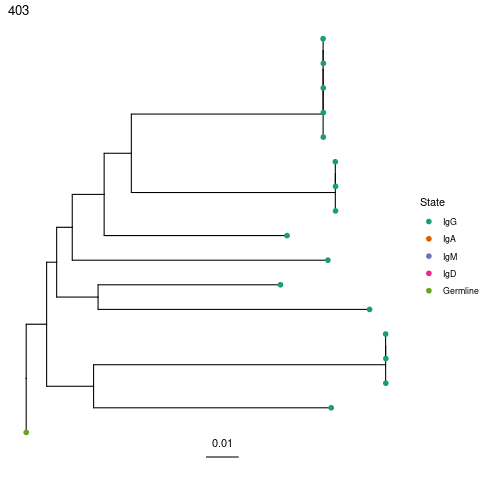

In [37]:
%%R
# Plot the largest tree
plots[[1]]

In [38]:
%%R
# Save PDF of all trees
dir.create("../results/dowser_tutorial", recursive=TRUE)
treesToPDF(plots, file="../results/dowser_tutorial/final_data_trees.pdf", nrow=2, ncol=2)

png 
  2 


## More elaborate tree plots

Plot trees so that tips are colored by cell type, scaled by sample day, and labelled by isotype.


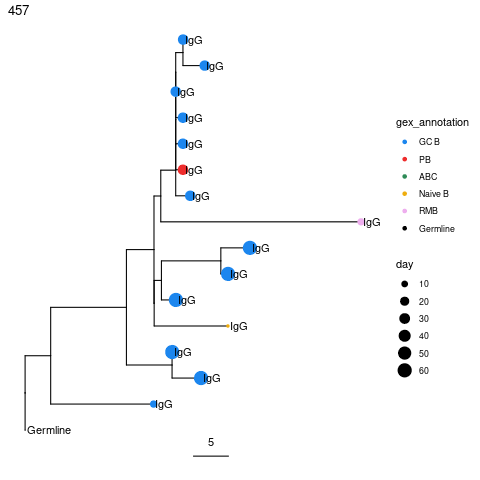

In [39]:
%%R
suppressPackageStartupMessages(library(ggtree))
# Scale branches to mutations rather than mutations/site
trees = scaleBranches(trees)
# Make fancy tree plot of second largest tree
plotTrees(trees, scale=5)[[2]] +
geom_tippoint(aes(colour=gex_annotation, size=day)) +
geom_tiplab(aes(label=isotype), offset=0.002) +
scale_colour_manual(values = col_anno)

## Reconstruct intermediate sequences

Get the predicted intermediate sequence at an internal node in the second largest tree. Dots represent IMGT gaps.


                                                                                                                                                                                                                                                                                                                                                                                                                          IGH 
"CAGGTCCAGCTGGTGCAGTCTGGGGCT...GAGGTGAAGAAGCCTGGGTCCTCGGTGAAGGTCTCCTGCAAGGCCTCTGGAGGCACCTTC............AGCAGCTATGCTATCAGCTGGGTGCGACAGGCCCCTGGACAAGGGCTTGAGTGGATGGGAGGGATCATCCCTATC......TATGGTACAGCAAACTACGCACAGAAGTTCCAG...GGCAGAGTCACGATTACCGCGGACGAATCCACGAGCACAGCCTACATGGAGCTGAGCAGCCTGAGATCTGAGGACACGGCCGTGTATTACTGTGCGAGAAGTCCTGACTATGGTTCGGGGACTTACCTTAACTACTACTACTACTACTTGGACGTCTGGGGCAAAGGGACCACGGTCACCGTCTCCTCASSS" 


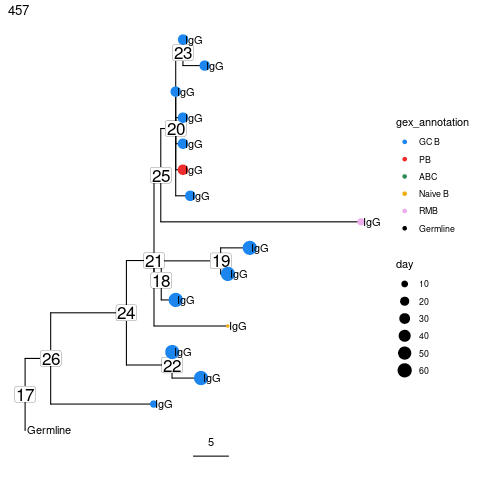

In [40]:
%%R
suppressPackageStartupMessages(library(ggtree))
# Collapse nodes with identical sequences
trees = collapseNodes(trees)
# node_nums=TRUE labels each internal node
p = plotTrees(trees, node_nums=TRUE, labelsize=6, scale=5)[[2]] +
   geom_tippoint(aes(colour=gex_annotation, size=day)) + 
   geom_tiplab(aes(label=isotype), offset=0.002) + 
   scale_colour_manual(values = col_anno)
print(p)
# Get sequence at node 26 for the second clone_id in trees
getSeq(trees, clone=trees$clone_id[2], node=26)

## Test for measurable evolution

Perform root-to-tip regression on each tree to detect if later-sampled timepoints are more diverged from the germline. See this reference for more detail:

Hoehn, K. B. et al. (2021) Human B cell lineages engaged by germinal centers following influenza vaccination are measurably evolving. bioRxiv. https://doi.org/10.1101/2021.01.06.425648


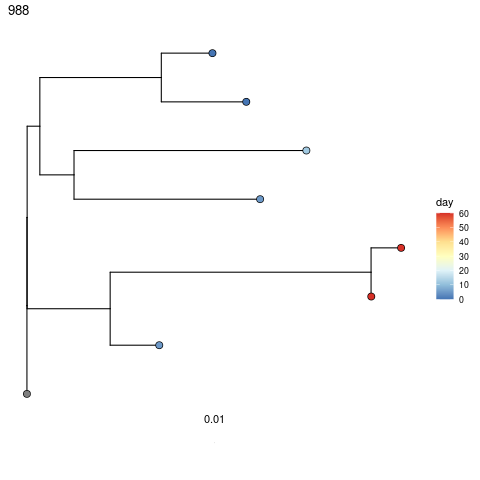

In [41]:
%%R
# Correlation test
trees = correlationTest(trees, time="day")

# remove trees with one timepoint, order by p value
trees = filter(trees, !is.na(p))
trees = trees[order(trees$p),]

# Fancy tree plots coloring tips by sample day
p = plotTrees(trees)
p = lapply(p, function(x)
   x + 
  geom_tippoint(aes(fill=day),shape=21, size=3)+
  scale_fill_distiller(palette="RdYlBu"))

# Save all trees to a pdf file
treesToPDF(p,file="../results/dowser_tutorial/time_data_trees.pdf")

select(trees, clone_id, slope, correlation, p)
print(p[[1]])

# References

## B cell phylo 

Hoehn, K. B. et al. (2016) The diversity and molecular evolution of B-cell receptors during infection. MBE. https://doi.org/10.1093/molbev/msw015

Hoehn, K. B. et al. (2019) Repertoire-wide phylogenetic models of B cell molecular evolution reveal evolutionary signatures of aging and vaccination. PNAS 201906020.

Hoehn, K. B. et al. (2020) Phylogenetic analysis of migration, differentiation, and class switching in B cells.
bioRxiv. https://doi.org/10.1101/2020.05.30.124446

Hoehn, K. B. et al. (2021) Human B cell lineages engaged by germinal centers following influenza vaccination are measurably evolving. bioRxiv. https://doi.org/10.1101/2021.01.06.425648


## BCR analysis

Gupta,N.T. et al. (2017) Hierarchical clustering can identify b cell clones
with high confidence in ig repertoire sequencing data. The Journal of
Immunology, 1601850.

Gupta,N.T. et al. (2015) Change-o: A toolkit for analyzing large-scale b cell
immunoglobulin repertoire sequencing data. Bioinformatics, 31, 3356–3358.

Nouri,N. and Kleinstein,S.H. (2018a) A spectral clustering-based method
for identifying clones from high-throughput b cell repertoire sequencing data.
Bioinformatics, 34, i341–i349.

Nouri,N. and Kleinstein,S.H. (2018b) Optimized threshold inference for
partitioning of clones from high-throughput b cell repertoire sequencing
data. Frontiers in immunology, 9.

Stern,J.N. et al. (2014) B cells populating the multiple sclerosis brain
mature in the draining cervical lymph nodes. Science translational medicine,
6, 248ra107–248ra107.


Vander Heiden,J.A. et al. (2017) Dysregulation of b cell repertoire
formation in myasthenia gravis patients revealed through deep sequencing.
The Journal of Immunology, 1601415.

Yaari,G. et al. (2012) Quantifying selection in high-throughput
immunoglobulin sequencing data sets. Nucleic acids research, 40,
e134–e134.

Yaari,G. et al. (2013) Models of somatic hypermutation targeting and
substitution based on synonymous mutations from high-throughput
immunoglobulin sequencing data. Frontiers in immunology, 4, 358.
